# Sudoku Solver (v3)

Close to final form.

Objectives:

1. Assess effectiveness and performance against different test cases
 1. Back tracking
 2. Back tracking + constraint propogation
 3. Deductive logic
 4. Solution X or Dancing Links?
3. Learn some more Pandas + Matplotlib (draw some pretty graphs)
4. ~~Assess performance against other implementations~~


## Supporting Packages

**TODO**: Brief description of [sudoku](sudoku.py) and [puzzlegrid](puzzlegrid.py) libraries.


In [1]:
import sudoku as su
import puzzlegrid as pg

**TODO**: Brief description of why we need the following

In [2]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 6]
pd.set_option('precision', 4)


## Help functions

**TODO:** Print puzzles descriptions.


In [3]:
def print_puzzle(puzzle, **args):
    display(HTML(puzzle.as_html(**args)))

def print_2_puzzles(puz1, puz2, **args):
    display(HTML('<table><tr><td>' + puz1.as_html(**args) + '</td><td>' + puz2.as_html() + '</td></tr></table>'))

def update_progress(label, current, total, time_so_far, test_case):
    clear_output(wait=True)
    display(HTML(f'<progress style="width: 100%" max={total} value={current}>{current} out of {total}</progress>'))
    if test_case:
        display(HTML(f"<p>Working on {label}: <i>{test_case['label']}</i> ({current} of {total}), time so far {time_so_far:.2f}s</p>"))
    else:
        display(HTML(f"<p>Completed {total} test cases in {time_so_far:.2f} seconds</p>"))
    return

## Example class usage

Create a puzzle in `SudokuPuzzle`. There are sample puzzles in the [sudoku](sudoku.py#line=423) module.


In [4]:
print("\n".join([x['label'] for x in su.SAMPLE_PUZZLES]))

SMH 1
SMH 2
KTH 1
Rico Alan Heart
SMH 3
SMH 4
SMH 5
Greg [2017]
Rico Alan 1
Rico Alan 2
Rico Alan Border #1
Rico Alan 4
Qassim Hamza
Rico Alan 3
World's Hardest Sudoku 2012
AI escargot


In [5]:
puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(puzzle)
print_puzzle(puzzle)

8,9,,4,,,,5,6
1,4,,3,5,,,9,
,,,,,,8,,
9,,,,,,2,,
,8,,9,6,5,,4,
,,1,,,,,,5
,,8,,,,,,
,3,,,2,1,,7,8
4,2,,,,6,,1,3


The solver classes are defined in [sudoku](sudoku.py). A number of different strategies are defined, in separate classes. There's a helper class `SudokuSolver` which will "just work" without too much fuss.

In [6]:
solver = su.SudokuSolver()
solver.solve(puzzle)
print_2_puzzles(original, puzzle, show_possibilities=2)

8,9,,4,"{1, 7}","{2, 7}",,5,6
1,4,,3,5,,{7},9,"{2, 7}"
,,,,,,8,"{2, 3}",
9,,,,,,2,,"{1, 7}"
,8,,9,6,5,,4,"{1, 7}"
,"{6, 7}",1,,,,,,5
,,8,"{5, 7}",,,,"{2, 6}",
"{5, 6}",3,,{5},2,1,,7,8
4,2,,,,6,"{9, 5}",1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


# Sudoku Solution Strategies

Running some timing tests. Using 2017 Macbook Pro (2.3 GHz Intel Core i5).

These are the strategies implemented in the `*Solver` classes:

In [7]:
print("\n".join([x for x in su.SOLVERS.keys()]))

backtracking
constraintpropogation
deductive


We have some test puzzles in the `sudoku` module. Each puzzle is marked with a "difficulty level", which is based on the number of starting clues. We're using the `include_levels` list below to select which levels to include in our tests.

In [8]:
include_levels = ['Kids', 'Easy', 'Moderate', 'Hard']  # , 'Diabolical', 'Pathalogical']
test_cases = [x for x in su.SAMPLE_PUZZLES if x['level'] in include_levels]

NUM_SAMPLES=5

The final bit of code to introduce is the `PuzzleTester` class. We add puzzles as test cases and then run different solving strategies against them. The tester class will track performance times.

In [9]:
pt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
pt.add_testcases(test_cases)

## Backtracking

**TODO:** Explanation of algorithm. Implemented in `BacktrackingSolver`.

The primary advantage of backtracking is that it can solve any puzzle, given sufficient time. In test code below, limiting `include_levels` to `Kids`, `Easy`, and `Moderate` will complete the testing in ~1 second. On the other hand:

* `Hard` extends the running time to ~15 seconds.
* `Diabolical` takes ~5 minutes.
* `Pathalogical` takes ~36 minutes.

The time is due to the poor performance of the "naive" backtracking algorithm on some (but not all) puzzles. We're also solving each puzzle `NUM_SAMPLES` times (5 by default). We then average out the running times.

In [10]:
method = 'backtracking'
solver = su.BacktrackingSolver()
n = pt.run_tests(solver, method, callback=update_progress)

Can see some results below. Sorted by time taken (longest first). Plain backtracking is always slower, and on some puzzles it's a huge difference. 

In [11]:
df = pd.DataFrame(pt.get_test_results())
df.sort_values(by=method, ascending=False)

,label,level,starting_clues,backtracking
5,SMH 4,Hard,22,1.3753
6,SMH 5,Hard,25,0.6342
7,Greg [2017],Hard,21,0.6141
1,SMH 2,Easy,24,0.1977
3,Rico Alan Heart,Easy,22,0.0901
4,SMH 3,Moderate,26,0.0856
2,KTH 1,Easy,30,0.0119
0,SMH 1,Kids,31,0.0075


## Constaint Propogation

*TODO*: Explanation of backtracking + constraint propogation.



In [12]:
method = 'constraintpropogation'
solver = su.ConstraintPropogationSolver()
n = pt.run_tests(solver, method, callback=update_progress)

This way is generally much faster. 

In [13]:
df = pd.DataFrame(pt.get_test_results())
df.sort_values(by=method, ascending=False)

,label,level,starting_clues,backtracking,constraintpropogation
4,SMH 3,Moderate,26,0.0856,0.0637
7,Greg [2017],Hard,21,0.6141,0.0635
3,Rico Alan Heart,Easy,22,0.0901,0.0552
5,SMH 4,Hard,22,1.3753,0.0354
6,SMH 5,Hard,25,0.6342,0.0265
1,SMH 2,Easy,24,0.1977,0.0065
2,KTH 1,Easy,30,0.0119,0.0035
0,SMH 1,Kids,31,0.0075,0.0015


## Deductive Logic

There are some [common Sudoku strategies](https://www.sudokudragon.com/sudokustrategy.htm) which aren't too hard to code and I want to test them. Their primary advantage is that they are fast, but they're not always able to solve all puzzles. The more difficult ones aren't usually solved this way, and we have to fall back to backtracking to finish them off. Still, being able to solve even a few cells with a deductive logic technique can dramatically improve the performance time, because the backtracking solution has fewer search paths to go through.

The three coded here are:

* Single Possibilities (TODO: explain)
* Only Squares (TODO: explain)
* Two out of Three Rule (TODO: explain)

### Single Possibilities


In [14]:
method = 'deductive'
solver = su.DeductiveSolver()
p = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(p)

In [15]:
solver.solve_single_possibilities(p)
print_2_puzzles(original, p)

8,9,,4,,,,5,6
1,4,,3,5,,,9,
,,,,,,8,,
9,,,,,,2,,
,8,,9,6,5,,4,
,,1,,,,,,5
,,8,,,,,,
,3,,,2,1,,7,8
4,2,,,,6,,1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


### Only Squares


In [16]:
p = copy.deepcopy(original)
solver.solve_only_squares(p)
print_2_puzzles(original, p)

8,9,,4,,,,5,6
1,4,,3,5,,,9,
,,,,,,8,,
9,,,,,,2,,
,8,,9,6,5,,4,
,,1,,,,,,5
,,8,,,,,,
,3,,,2,1,,7,8
4,2,,,,6,,1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


### Two out of Three

This idea comes from [Sudoku Dragon's Two out of Three Rule](https://www.sudokudragon.com/forum/twothreestrategy.htm). The code is more complicated than any of the other methods which makes its performance dissapointing. On its own, it is not able to solve any puzzles. It can solve a few cells though.


In [17]:
p = copy.deepcopy(original)
solver.solve_two_out_of_three(p)
print_2_puzzles(original, p)

8,9,,4,,,,5,6
1,4,,3,5,,,9,
,,,,,,8,,
9,,,,,,2,,
,8,,9,6,5,,4,
,,1,,,,,,5
,,8,,,,,,
,3,,,2,1,,7,8
4,2,,,,6,,1,3
8,9,,4,,,,5,6
1,4,6,3,5,8,,9,2


So how many cells did this method solve?

In [18]:
original.num_empty_cells() - p.num_empty_cells()

11

And that was on the easiest puzzle in the test suite. When solving "manually" it's actually quite a useful and easy technique to apply. My code is pretty awful though and its effectiveness led me to lose motivation for coding any more complicated methods!

### Hybrid

Since the deductive methods can't solve all puzzles we have a hybrid approach which will attempt to use the deductive methods as long as possible, and then fall back to backtracking + constraint propogation. It *should* be faster than CP alone.

First we'll try with repeated applications of *just* the deductive methods.


In [19]:
method = 'deductive'
solver = su.DeductiveSolver(use_backtracking=False)
n = pt.run_tests(solver, method, callback=update_progress)

In [20]:
def color_nan(val):
    color = 'red' if pd.isnull(val) else ''
    return 'color: %s' % color

df = pd.DataFrame(pt.get_test_results())
df.sort_values(by=method, ascending=False)
df.style.applymap(color_nan)

,label,level,starting_clues,backtracking,constraintpropogation,deductive
0,SMH 1,Kids,31,0.007527,0.001485,0.00234
1,SMH 2,Easy,24,0.1977,0.006495,0.005248
2,KTH 1,Easy,30,0.01193,0.003481,0.002515
3,Rico Alan Heart,Easy,22,0.09008,0.05517,0.01647
4,SMH 3,Moderate,26,0.08557,0.06366,nan
5,SMH 4,Hard,22,1.375,0.03537,nan
6,SMH 5,Hard,25,0.6342,0.02645,nan
7,Greg [2017],Hard,21,0.6141,0.06347,nan


Now we'll use constraint propogation + backtracking if the deductive methods fail.


In [21]:
method = 'combination'
solver = su.DeductiveSolver(use_backtracking=True)
n = pt.run_tests(solver, method, callback=update_progress)

In [22]:
df = pd.DataFrame(pt.get_test_results())
df.sort_values(by=method, ascending=False)
df.style.applymap(color_nan).format({m: '{:.3f}' for m in su.SOLVERS}).format({method: '{:.3f}'})

,label,level,starting_clues,backtracking,constraintpropogation,deductive,combination
0,SMH 1,Kids,31,0.008,0.001,0.002,0.001
1,SMH 2,Easy,24,0.198,0.006,0.005,0.006
2,KTH 1,Easy,30,0.012,0.003,0.003,0.001
3,Rico Alan Heart,Easy,22,0.090,0.055,0.016,0.013
4,SMH 3,Moderate,26,0.086,0.064,nan,0.056
5,SMH 4,Hard,22,1.375,0.035,nan,0.018
6,SMH 5,Hard,25,0.634,0.026,nan,0.014
7,Greg [2017],Hard,21,0.614,0.063,nan,0.045


# Evaluating the Solution Algorithms

Add more test cases from [Peter Norvig](https://norvig.com/sudoku.html). Yes. [that Peter Norvig](http://aima.cs.berkeley.edu/).

If the test results file exists we'll use the results from earlier. Otherwise, this will re-run all the tests which took ~3.5 hours on my 2017 Macbook Pro (2.3 GHz Intel Core i5).


In [23]:
import os.path
import datetime

TEST_RESULTS = "sudoku_test_results.pkl"

if os.path.isfile(TEST_RESULTS):
    df = pd.read_pickle(TEST_RESULTS)
else:
    print(f"Fenerating {TEST_RESULTS} at {datetime.datetime.now()}...")
    pt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
    pt.add_testcases([x for x in su.SAMPLE_PUZZLES])
    pt.add_testcases(pg.from_file("data/hardest.txt", level="Hard"))
    pt.add_testcases(pg.from_file("data/top95.txt", level="Diabolical"))
    print(f"Using {pt.num_testcases()} test cases")
    for m in su.SOLVERS:
        solver = su.SudokuSolver(method=m)
        pt.run_tests(solver, m, callback=update_progress)
    df = pd.DataFrame(pt.get_test_results())
    df.to_pickle(TEST_RESULTS)
    print(f"Finished  {TEST_RESULTS} at {datetime.datetime.now()}")


In [24]:
df.describe()

,starting_clues,backtracking,constraintpropogation,deductive
count,122.0000,122.0000,122.0000,122.0000
mean,21.1885,46.7597,0.5639,0.2538
std,3.4023,159.5886,1.7126,0.7608
min,17.0000,0.0058,0.0013,0.0014
25%,17.0000,0.3078,0.0171,0.0200
50%,22.0000,2.0860,0.0582,0.0447
75%,23.0000,11.8935,0.1904,0.1210
max,31.0000,1173.9083,12.0758,5.2194


So, yeah. Backtracking alone is appalling. Look it.

* 75% of the test cases are solved in ~0.2 seconds with the constraint propogation solution, but we need ~12 seconds using backtrackng alone.
* Mean time is terrible for backtracking alone (~46 seconds). 

You can see the variability better with the following plot.

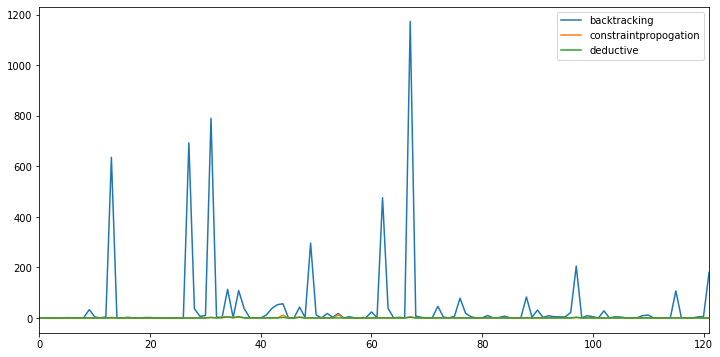

In [25]:
solvers = df.columns[3:]
axs = df[solvers].plot()

So, at this point, going to stop testing with backtracking alone. But there are a few puzzles that seem to be particularly difficult for the constraint propogation solution, so let's look at those.

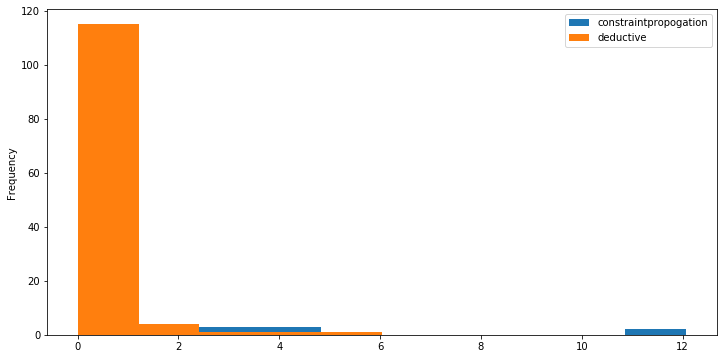

In [26]:
method = 'constraintpropogation'
axs = df[solvers.drop('backtracking')].plot(kind='hist')

## Constraint Propogation

**TODO**: Explanation of CP.

### Evaluating CP

The majority of the test puzzles are solved in < ~ 0.2 seconds, however there are some that take longer, up to a maxiumum of 12 seconds.

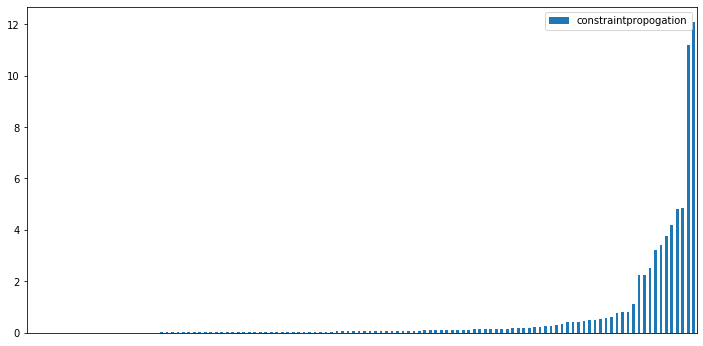

In [27]:
method = 'constraintpropogation'
axs = df.sort_values(by=method)[[method]].plot(kind='bar')
axs.xaxis.label.set_visible(False)
axs.xaxis.set_ticks([])
plt.show()

Let's take a look at those puzzles that take so much longer to solve and see if we can work out what's happening there.

In [28]:
def highlight_where_backtracking_faster(s):
    if s.constraintpropogation > s.backtracking:
        return ['background-color: yellow; color: black'] * len(s)
    else:
        return [''] * len(s)

method = 'constraintpropogation'
ndf = df.sort_values(by=method, ascending=False).head(n=15)
ndf.style.apply(highlight_where_backtracking_faster, axis=1).bar(subset=[method], color='orange').format({m: '{:.3f}' for m in su.SOLVERS})

,label,level,starting_clues,backtracking,constraintpropogation,deductive
54,data/top95.txt:28,Diabolical,17,17.757,12.076,0.063
44,data/top95.txt:18,Diabolical,17,56.354,11.171,2.268
67,data/top95.txt:41,Diabolical,17,1173.908,4.840,3.015
33,data/top95.txt:7,Diabolical,17,1.697,4.804,1.025
47,data/top95.txt:21,Diabolical,17,43.075,4.180,2.395
34,data/top95.txt:8,Diabolical,17,113.328,3.775,4.442
36,data/top95.txt:10,Diabolical,17,108.590,3.400,5.219
35,data/top95.txt:9,Diabolical,17,1.691,3.226,0.491
97,data/top95.txt:71,Diabolical,17,205.605,2.515,2.329
31,data/top95.txt:5,Diabolical,17,790.428,2.263,1.707


Interesting points:

* Puzzles 7 and 9 (highlighted yellow) actually take longer to solve with the constraint propogation solution than simple backtracking
* Puzzles 21 and 46 look like good candidates for looking at closer, because the backtracking time isn't so long that we can't wait for profiler output if we want to compare profiles
* Puzzle 42 looks like a good place to start though: < ~1 second (highlighted green), deductive method on the same puzzle *much* faster, and backtracking time not so long tha we can't wait.

So let's look at Puzzle 42 (answer to the Ultimate Question?), using the built in Jupyet profiler tools. First though, a quick check that the total time matches up. According to original testing performance, this should take ~8 microseconds (ms).


In [29]:
puzzle42 = '......8.16..2........7.5......6...2..1....3...8.......2......7..3..8....5...4....'
puzzle.init_puzzle(puzzle42)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 822 ms, sys: 9.39 ms, total: 831 ms
Wall time: 910 ms


True

That looks OK. So reset the puzzle and profile below. The profiler itself adds some overhead so this takes slightly longer (~1.2 seconds).

In [30]:
puzzle.init_puzzle(puzzle42)
s = su.SudokuSolver(method=method)
%prun s.solve(puzzle)

         2059321 function calls (2030331 primitive calls) in 1.277 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   398932    0.384    0.000    0.689    0.000 sudoku.py:100(get_allowed_values)
    57980    0.256    0.000    0.880    0.000 puzzlegrid.py:260(next_best_empty_cell)
   398932    0.202    0.000    0.202    0.000 puzzlegrid.py:297(get_allowed_values)
   456848    0.118    0.000    0.118    0.000 sudoku.py:52(box_xy_to_num)
  28991/1    0.094    0.000    1.276    1.276 sudoku.py:215(_solve_backtracking)
    28990    0.051    0.000    0.118    0.000 puzzlegrid.py:177(set)
    28926    0.041    0.000    0.085    0.000 sudoku.py:73(clear)
    28990    0.034    0.000    0.161    0.000 sudoku.py:60(set)
    28926    0.027    0.000    0.033    0.000 puzzlegrid.py:206(clear)
   341006    0.024    0.000    0.024    0.000 {built-in method builtins.len}
    28990    0.015    0.000    0.060    0.000 puzzlegrid.py:309(is_all

Notes:

* 399K calls to `get_allowed_values`. The first entry is in [sudoku.py](sudoku.py#line_88), which gets the allowed values for the box, then calls the same method in the [parent class](puzzlegrid.py#line_321) to return the intersection of allowed cells in that row, column and box.
* Recurses into `solve_constraintpropogation` 29K times.

Compare the performance of #42 to #46. Expect #46 to take ~2.5 seconds.

In [31]:
puzzle46 = '.834.........7..5...........4.1.8..........27...3.....2.6.5....5.....8........1..'
puzzle.init_puzzle(puzzle46)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 256 ms, sys: 4.13 ms, total: 260 ms
Wall time: 274 ms


True

OK, this is weird. That was supposed to take ~2.5 seconds and instead finished in ~0.3 seconds. Let's run it again...and again. And this time we'll output some of the stats collected by the solver itself:

* Max Depth: The deepest stack-depth the recursion reached
* Backtracks: The number of "mistakes" made by the algorithm that resulted in it backtracking to a prior state


In [32]:
puzzle = su.SudokuPuzzle()
solver = su.SudokuSolver(method=method)
for i in range(5):
    print(f"RUN {i}")
    puzzle.init_puzzle(starting_grid=puzzle46)
    assert(not puzzle.is_solved())
    %time solver.solve(puzzle)
    print(f"Max Depth={solver.solver.max_depth}; Backtracks={solver.solver.backtrack_count}\n")

RUN 0
CPU times: user 2.67 s, sys: 23.3 ms, total: 2.7 s
Wall time: 2.92 s
Max Depth=63; Backtracks=105917

RUN 1
CPU times: user 2.64 s, sys: 19.2 ms, total: 2.66 s
Wall time: 2.73 s
Max Depth=63; Backtracks=105917

RUN 2
CPU times: user 223 ms, sys: 1.06 ms, total: 224 ms
Wall time: 225 ms
Max Depth=63; Backtracks=8766

RUN 3
CPU times: user 246 ms, sys: 2.34 ms, total: 248 ms
Wall time: 293 ms
Max Depth=63; Backtracks=8766

RUN 4
CPU times: user 240 ms, sys: 2.21 ms, total: 243 ms
Wall time: 276 ms
Max Depth=63; Backtracks=8766



In testing, the first two usually take ~2.5 seconds, and the last 3 take ~220 ms. Even though it's exactly the same puzzle being solved by exactly the same algorithm.

Difference is caused by the return order of the set of allowed values. Since the values are returned in a set, the order of the set members is not guaranteed to be consistent. When the order is slightly different, then the backtracking can take dramatically different search paths, with consequent impacts on run time. You can see this in the `Backtracks` reported (~106K vs ~9K).

In this specific case, one of the cells has allowed values (1, 9). If "1" is chosen then the solution takes 2.5 seconds to find. However if the "9" is chosen, then the search takes ~220 ms. 

If I modify the algorithm to always sort the allowed values then the performance time is always consistent. Otherwise there's a certain amount of randmomness to it.

The other change is to recreate the `puzzle` instance each time. When I do that, the performance remains consistent, because the set order remains consistent. Not sure why that is.


# Next Steps

Still to do:

* ~~Not sure if the change in set ordering happens when running tests in `PuzzleTester` -- should check and see if that impacts results~~ (I get an average but what's the stddev?)
* Could force the set ordering to be deterministic and test with different preferred sort orders. Expect to find the same range of performance times, even as times for individual puzzles might vary.

On that first point: I changed the code so that I get the expected behaviour. The method `run_single_test` was creating a new `SudokuPuzzle` instance each and every time it was called. I changed it to re-use the same instance and can now observe the variation. Not sure if that's really desireable or not.


In [33]:
newpt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=10)
newcases = [x for x in pg.from_file("data/top95.txt", level="Diabolical") if x['label'] == 'data/top95.txt:46']
newpt.add_testcases(newcases)
newpt.num_testcases()

1

In [34]:
method

'constraintpropogation'

In [35]:
solver = su.SudokuSolver(method=method)
newpt.run_tests(solver, method, callback=update_progress)
newdf = pd.DataFrame(newpt.get_test_results())
newdf

,label,level,starting_clues,constraintpropogation
0,data/top95.txt:46,Diabolical,17,0.7904


# Just for Fun: Cheating

Occurred to me that the way I've designed the puzzle and solver classes opens the way to having a "cheating" solver. Basically a solver that over-writes the puzzle with a pre-programmed sequence of numbers that obey the rules but do not match the original puzzle clues.

So just for fun let's see how easy that is to do and how I could improve the puzzle class to detect and block attempts to "cheat".


In [36]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Easiest way to cheat would be to trick the is_solved() method on the puzzle to always returning True"""
        puzzle._num_empty_cells = 0
        return True

puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)
puzzle.is_solved()

True

Gah. That was *too* easy. So maybe instead we should at least make sure that `is_solved()` does a cell-by-cell check to see that all values are really filled in.

In [37]:
class AntiCheatSudoku(su.SudokuPuzzle):
    def is_solved(self):
        if self.is_puzzle_valid():
            for i in range(self.max_value()):
                for j in range(self.max_value()):
                    if self.is_empty(i, j):
                        return False
            return True
        else:
            return False
    
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)

True

In [38]:
puzzle.is_solved()

False

A little better -- the puzzle instance at least knows it is not solved, even though the "solver" reported that it was. So all we'd need to do now is make sure our test harness noticed the discrepency and threw away such results.

In [39]:
pt._puzzle_class=AntiCheatSudoku
method = 'cheat'
solver = CheatingSolver()
pt.run_tests(solver, method)

8

In [40]:
df = pd.DataFrame(pt.get_test_results())
df

,label,level,starting_clues,backtracking,constraintpropogation,deductive,combination,cheat
0,SMH 1,Kids,31,0.0075,0.0015,0.0023,0.0014,None
1,SMH 2,Easy,24,0.1977,0.0065,0.0052,0.0059,None
2,KTH 1,Easy,30,0.0119,0.0035,0.0025,0.0014,None
3,Rico Alan Heart,Easy,22,0.0901,0.0552,0.0165,0.0133,None
4,SMH 3,Moderate,26,0.0856,0.0637,NaN,0.0557,None
5,SMH 4,Hard,22,1.3753,0.0354,NaN,0.0182,None
6,SMH 5,Hard,25,0.6342,0.0265,NaN,0.0137,None
7,Greg [2017],Hard,21,0.6141,0.0635,NaN,0.0451,None


So I had to change `PuzzleTester` class to check the return value of `run_single_test` (which returns the value of `puzzle.is_solved()`) so at least if the puzzle asserts that it is NOT solved then no result is recorded for the solver.

## Cheating Attempt #2

So since our really simple cheater no longer works I guess we'll need a more sophisticated version. We could just fill in the blank cells with "1" (or any other value) but then the `is_puzzle_valid` check would fail, at which point we may as well solve it properly. Let's just verify that that's true...


In [41]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Write some random value into empty cells"""
        for i in range(puzzle.max_value()):
            for j in range(puzzle.max_value()):
                if puzzle.is_empty(i, j):
                    # can't use set() because it checks validity!
                    puzzle._grid[i][j] = 1
        puzzle._num_empty_cells = 0
        return True

In [42]:
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)
puzzle.is_solved()

False

Correct! And that's because the puzzle isn't valid, right?

In [43]:
puzzle.is_puzzle_valid()

False

Excellent! 

So maybe what our cheat needs to do is overwrite *all* cells in a rule-abiding way. We won't be actually solving the original puzzle. Basically, we're just writing a "pre-solved" puzzle over the top.

In [44]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Write a pre-solved puzzle in over the top of the provided one"""
        starting_values = [0, 3, 6, 1, 4, 7, 2, 5, 8]
        max_value = puzzle.max_value()
        puzzle.clear_all()
        for i in range(max_value):
            for j in range(max_value):
                #print(i, j, (starting_values[i] + j) % max_value + 1)
                puzzle.set(i, j, (starting_values[i] + j) % max_value + 1)
        return True

In [45]:
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)
puzzle.is_solved()

True

The whole point of this is to be faster than a real solver, so let's test performance.

In [62]:
method = 'cheat'
all_methods = list(su.SOLVERS.keys())
all_methods.append(method)

pt.run_tests(solver, method)
df = pd.DataFrame(pt.get_test_results())
df.style.highlight_max(axis=1, color='red', subset=all_methods).highlight_min(axis=1, color='green', subset=all_methods).format({m: '{:.3f}' for m in all_methods})

,label,level,starting_clues,backtracking,constraintpropogation,deductive,combination,cheat
0,SMH 1,Kids,31,0.008,0.001,0.002,0.001386,0.001
1,SMH 2,Easy,24,0.198,0.006,0.005,0.005942,0.001
2,KTH 1,Easy,30,0.012,0.003,0.003,0.001407,0.001
3,Rico Alan Heart,Easy,22,0.090,0.055,0.016,0.01327,0.001
4,SMH 3,Moderate,26,0.086,0.064,nan,0.05569,0.001
5,SMH 4,Hard,22,1.375,0.035,nan,0.01817,0.001
6,SMH 5,Hard,25,0.634,0.026,nan,0.0137,0.001
7,Greg [2017],Hard,21,0.614,0.063,nan,0.04506,0.001


## Catching Cheat #2

To prevent the new cheat we basically need to compare the puzzle with a copy of the original. That way we can detect that the starting clues have been over written.

We can't do this in the `SudokuPuzzle` itself. Python doesn't really have `private` attributes, [just a naming convention](https://docs.python.org/3/tutorial/classes.html#tut-private) that signals "hey, you're not supposed to muck around with this", but we've already seen that we can pretty much ignore that and modify the class's internals. And since we're trying to guard against cheating we can assume an attacker will happily ignore convention.

If we assume that the caller (test harness) can be trusted then we can let the caller verify that the original puzzle is OK. We'll just need a function that confirms if the starting clues in one puzzle also exist in the second.


In [47]:
def has_same_clues(a, b):
    """Returns true if the non empty cells in a have the same value in b"""
    if a.max_value() != b.max_value():
        return False
    
    for i in range(a.max_value()):
        for j in range(a.max_value()):
            if not a.is_empty(i, j) and a.get(i, j) != b.get(i, j):
                return False
    return True

In [48]:
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(puzzle)
has_same_clues(original, puzzle)

True

In [49]:
solver.solve(puzzle)
puzzle.is_solved()

True

In [50]:
has_same_clues(original, puzzle)

False

Putting it all together, let's ~~monkey patch~~ override the test harness instance and make sure it throws away test results if the solver has cheated.

In [51]:
class AntiCheatTester(pg.PuzzleTester):
    def run_single_test(self, test_case, puzzle, solver):
            """Checks that the solver has really solved the puzzle"""
            puzzle.init_puzzle(test_case['puzzle'])
            original = copy.deepcopy(puzzle)
            solver.solve(puzzle)
            if has_same_clues(original, puzzle):
                self._last_was_solved = puzzle.is_solved()
            else:
                self._last_was_solved = False
            return self._last_was_solved
    
newpt = AntiCheatTester(puzzle_class=AntiCheatSudoku, test_samples=NUM_SAMPLES)
newpt.add_testcases(test_cases)
newpt.num_testcases()

8

In [52]:
newpt.run_tests(solver, method)
df = pd.DataFrame(newpt.get_test_results())
df

,label,level,starting_clues,cheat
0,SMH 1,Kids,31,None
1,SMH 2,Easy,24,None
2,KTH 1,Easy,30,None
3,Rico Alan Heart,Easy,22,None
4,SMH 3,Moderate,26,None
5,SMH 4,Hard,22,None
6,SMH 5,Hard,25,None
7,Greg [2017],Hard,21,None


OK! Our cheating solver has had no results recorded for it, because the answer it gives does not match the starting clues!

There are probably ways to defeat these checks, particularly in a language like Python where "monkey patching" is a thing and everything is dynamic. That might be a fun way to learn more about the internals of Python, but for now I'm declaring this "done" and moving on to the next puzzle...

In [53]:
import datetime
print(datetime.datetime.now())

2020-09-11 13:44:52.121467


# Appendix

## Sources

Part of this exercise was to learn Python and Jupyter skills while also solving a problem that I found interesting. So I've largely avoided reading other people's solutions to solving Sudoku. However from time to time I've gotten stuck or just been curious about something and found the below sources useful.

* The "Top 95" and "Hardest" puzzle examples in the data directory come from [Solving Every Sudoku Puzzle (by Peter Norvig)](https://norvig.com/sudoku.html)
* [Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms) -- links to some sample puzzles (on Flickr of all places). Found via the [Wikipedia article on Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms).
* [AI Sudoku](http://www.aisudoku.com/index_en.html) -- collection of really hard puzzles.
* The [sudoku.py](sudoku.py) class has URLs to where I found some of the sample puzzles. I've attempted to use labels for them that credit the source, although it's not always clear where the original puzzle came from.
* Also used examples from [Simple sudoku solver using constraint propagation](https://gpicavet.github.io/jekyll/update/2017/12/16/sudoku-solver.html) (Grégory Picavet's Blog).


## Table formatting

Snippet below inserts some CSS to make the table look more like a Sudoku puzzle grid.


In [54]:
display(HTML('''
<style type="text/css">
.sudoku table {
    border: 3px solid red;
    text-align: center; 
    vertical-align: middle;
}

.sudoku td {
    width: 40px;
    height: 40px;
    border: 1px solid #F00;
}

.sudoku td:nth-of-type(3n) {    
    border-right: 3px solid red;
}

.sudoku tr:nth-of-type(3n) td {    
    border-bottom: 3px solid red;
}

.sudoku.solved table {
    border: 3px solid green;
}

.sudoku.solved td {
    border: 1px solid green;
}

.sudoku.solved td:nth-of-type(3n) {    
    border-right: 3px solid green;
}

.sudoku.solved tr:nth-of-type(3n) td {    
    border-bottom: 3px solid green;
}

</style>
'''))

Scratch.txt

#10: Rico Alan Border #1
Greg: Solved in 3 ms, 59 tests, 0 backtracks
Me: Solved in 3 ms

#13: Rico Alan #3
Greg: Invalid board!
Me: Solved in 1.771 s

#11: Rico Alan #4
Greg: Solved in 30 ms, 5396 tests, 2371 backtracks
Me: Solved in 26 ms

#12: Qassim Hamza
Greg: Solved in 15 ms
Me: Solved in 59 ms

#14: World's Hardest Sudoku 2012
Greg: Solved in 21 ms
Me: Solved in 30 ms

#15: AI escargot
Greg: Solved in 1 ms, 187 tests, 12 backtracks
Me: Solved in 4 ms